# Exploring and Preparing the Capture Repeat Table

This notebook explores the distribution of each variable collected in its the capture resource table and then combines variables into the high level indicator - proportion of capture

## Set up

In [234]:
# import packages
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
from zipfile import ZipFile
import os
import seaborn as sns
sns.set_theme()

pd.options.mode.chained_assignment = None

In [235]:
# unzipping survey tables

# specifying location of .zip and extraction location
sur_B_path="/home/rthoms/ocean_dep/sur_B/raw_data/Sur_B_03072023.zip"
sur_B_raw="/home/rthoms/ocean_dep/sur_B/raw_data/sur_B_raw"

# loading the .zip and creating a zip object
with ZipFile(sur_B_path, 'r') as zObject:

	# Extracting all the members of the zip
	# into a the specified location.
	zObject.extractall(
		path=sur_B_raw)

There is a parent table and many linked tables within the survey folder. For cleaning up the capture survey the main table (high level respondent information i.e. demographic questions), the practice table (fishing practices used), and capture table (quantity and use of capture) are relavent.

In [236]:
# specifiy location of raw data
# main survey table
ss_raw = os.path.join(sur_B_raw, "Form_4_0.csv")
df_ss = pd.read_csv(ss_raw)

# practice table
prac_raw = os.path.join(sur_B_raw, "fish_pract_table_1.csv")
df_prac = pd.read_csv(prac_raw, na_values='na')

# capture resource table
cap_raw = os.path.join(sur_B_raw, "capture_resource_table_2.csv")
df_cap_raw = pd.read_csv(cap_raw, dtype={'focal_resource': object})
df_cap_raw.columns

Index(['ObjectID', 'GlobalID', 'focal_resource', '_focal_resource_label',
       'prop_cap_hot_raw', 'prop_cap_hot', 'gear_used_hot', 'days_hot',
       'quant_cap_hot', 'cap_units_hot_label', 'cap_units_hot',
       ' cap_units_hot_other', 'sold_hot_raw', 'sold_hot', 'eaten_hot_raw',
       'eaten_hot', 'traded_hot_raw', 'traded_hot', 'offered_hot_raw',
       'offered_hot', 'sum_use_hot', 'sale_price_hot', 'sale_unit_hot',
       'sale_unit_hot_other', 'prop_cap_cold_raw', 'prop_cap_cold',
       'gear_used_cold', 'days_cold', 'quant_cap_cold', 'cap_units_cold',
       'cap_units_cold_label', 'cap_units_cold_other', 'sold_cold_raw',
       'sold_cold', 'eaten_cold_raw', 'eaten_cold', 'traded_cold_raw',
       'traded_cold', 'offered_cold_raw', 'offered_cold', 'sum_use_cold',
       'sale_price_cold', 'sale_unit_cold', 'sale_unit_cold_other',
       'quant_traded', 'unit_traded', 'product_recieved', 'quant_recieved',
       'unit_recieved', ' value_product_recieved', 'trade_season',
 

In [237]:
# Drop unnecessary columns and rename columns as necessary

# all columns that start with an underscore are labels from the data entry survey and can be dropped
df_wk = df_cap_raw[df_cap_raw.columns[~df_cap_raw.columns.str.startswith('_')]]

# gear_used_cold is a duplicate of gear_used_hot (used for data entry purposes) and can be dropped
col_to_drop = ['gear_used_cold']

# drop columns
df_wk.drop(col_to_drop, axis=1, inplace=True)

# rename the gear_used_hot column to match the column name in the practice table
df_wk.rename(columns={'gear_used_hot':'fish_pract'}, inplace=True)
df_wk

,ObjectID,GlobalID,focal_resource,prop_cap_hot_raw,prop_cap_hot,fish_pract,days_hot,quant_cap_hot,cap_units_hot_label,cap_units_hot,...,unit_traded_other,unit_recieved_other,resell_hot,resell_cold,ParentGlobalID,CreationDate,Creator,EditDate,Editor,product_other
0,7,5cf789e2-326d-4f7f-b604-4eed34dc194b,50,30,1.000000,glean,4.0,1.0,kilo(s),kgs,...,NaN,NaN,NaN,NaN,5242b473-cb0e-43ec-bc8f-6e626f4ee1d3,4/11/2023 6:30:30 AM,rthoms_wri,4/11/2023 6:30:30 AM,rthoms_wri,NaN
1,17,8428e640-0211-43dc-8b36-e01d7d672911,60,10,0.333333,glean,4.0,4.0,copo(s),cups,...,NaN,NaN,NaN,NaN,3f3b6da1-f4ee-467b-9647-aefe9851351f,4/11/2023 1:37:45 PM,rthoms_wri,4/11/2023 1:37:45 PM,rthoms_wri,NaN
2,18,bc568a6b-1ab4-46d1-ae1d-891489c1702b,61,7,0.233333,glean,4.0,5.0,copo(s),cups,...,NaN,NaN,NaN,NaN,3f3b6da1-f4ee-467b-9647-aefe9851351f,4/11/2023 1:37:45 PM,rthoms_wri,4/11/2023 1:37:45 PM,rthoms_wri,NaN
3,19,afbc75fc-4b4b-4d2e-b782-bac164055cd0,78,5,0.166667,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,3f3b6da1-f4ee-467b-9647-aefe9851351f,4/11/2023 1:37:45 PM,rthoms_wri,4/11/2023 1:37:45 PM,rthoms_wri,NaN
4,20,983d88e2-a973-408f-8dd0-1a17c7b5f961,75,8,0.266667,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,3f3b6da1-f4ee-467b-9647-aefe9851351f,4/11/2023 1:37:45 PM,rthoms_wri,4/11/2023 1:37:45 PM,rthoms_wri,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
419,442,eca907fe-52c4-469d-a7a8-23e24966b77f,52,8,0.266667,fence_trap,5.0,1.0,kilo(s),kgs,...,NaN,NaN,NaN,NaN,1dfbdb30-77d7-4a1e-aaf1-2a5bccccfb75,7/1/2023 12:17:35 PM,rthoms_wri,7/1/2023 12:17:35 PM,rthoms_wri,NaN
420,443,f2735213-e9c8-4baf-9282-7636dabede04,53,12,0.400000,fence_trap,8.0,2.0,kilo(s),kgs,...,NaN,NaN,NaN,NaN,1dfbdb30-77d7-4a1e-aaf1-2a5bccccfb75,7/1/2023 12:17:35 PM,rthoms_wri,7/1/2023 12:17:35 PM,rthoms_wri,NaN
421,444,0004eeea-57c8-47b7-8c1a-64bb1a2b0678,56,10,0.333333,fence_trap,8.0,2.0,kilo(s),kgs,...,NaN,NaN,NaN,NaN,1dfbdb30-77d7-4a1e-aaf1-2a5bccccfb75,7/1/2023 12:17:35 PM,rthoms_wri,7/1/2023 12:17:35 PM,rthoms_wri,NaN
422,445,36243b0a-fe8d-4ad1-88b2-a2f606bd19a7,78,7,0.233333,glean,10.0,4.5,copo(s),cups,...,NaN,NaN,NaN,NaN,d63dc568-99da-438e-bd41-3a79bf13b0d9,7/1/2023 12:17:38 PM,rthoms_wri,7/1/2023 12:17:38 PM,rthoms_wri,NaN


There is a parent table and many linked tables within the survey folder. For cleaning up the capture survey the main table (high level respondent information i.e. demographic questions), the practice table (fishing practices used), and capture table (quantity and use of capture) are relavent.

Some fishers caught one resource using multiple practices. In order for each row to represent one resource caught by a fisher using a given practice, rows representing more than one gear must be "exploded" 

In [238]:
# read practice column as a list
df_wk.fish_pract = df_wk.fish_pract.str.split(',')

# ecplode the df using the column
df_wk = df_wk.explode('fish_pract')

# break the df up into two sub dfs - those that have a practice recorded (focal resources) and those that do not (non-focal resources)
df_wk_na = df_wk[df_wk['fish_pract'].isna()]
df_wk_notna = df_wk[~df_wk['fish_pract'].isna()]

# drop the fish_pract colum from the entries without a practice recorded
df_wk_na.drop('fish_pract', axis=1, inplace=True)



There is information needed for analysis in the main parent table of the survey. This inludes the community (ccp) of the respondent and their gender. There is also inforamtion in the practice repeat table, including the practices (and gear) they use, whether they own the gear, and what proportion of the profits from the catch or the catch itself they have a right to. These two tables will be merged together. Since some fishers use more than one practice, this will result in the duplication of survey ids from the main table, since each practice must have its own resource information.

In [239]:
# Add important information from parent table and practice table to the capture table

# Isolate relevant columns from the main table
df_ss_sub=df_ss.loc[:, ['GlobalID','id','ccp','gender']]

# Rename GlobalID column to match with children IDs
df_ss_sub.rename(columns={'GlobalID':'ParentGlobalID'}, inplace=True)

# Isolate relevant columns from practice table
df_prac_sub=df_prac.loc[:, ['ParentGlobalID','fish_pract','owner','catch_proportion']]

# Join main table and practice table
# note that fishers who use two gears will be represented twice 
df_ss_prac = pd.merge(df_ss_sub,df_prac_sub,on='ParentGlobalID', how='right')


In [240]:
df_ss_pra_dup=df_ss_prac[df_ss_prac.duplicated(['id'], keep='first')]
len(df_ss_pra_dup)

26

The main/practice table must then be merged with the capture repeate table. These resource repeates will be merged to the main/practice table based on the Parent ID of the repeat (the respondent ID) and the practice used to catch the item from the practice table (avoiding unintended duplicates from the practice reapeats). There will be intended duplicates when fishers use more than one practice to catch the same resource.

No practice information was collected about non-focal resources captured. These must be merged seperately only using the Parent ID. Then these two subsets of the table will be merged back together.

In [241]:
# Merge demo/practice table with capture table

# for focal resource, merge on ID and practice 
df_wk_1 = pd.merge(df_ss_prac,df_wk_notna,on=['ParentGlobalID','fish_pract'], how='right')

# non focal resources can only be merged on ID (these will later be removed)
df_wk_2 = pd.merge(df_ss_prac,df_wk_na,on=['ParentGlobalID'], how='right')

# concatenate the two sub dfs
df_com = pd.concat([df_wk_1,df_wk_2])
df_com

,ParentGlobalID,id,ccp,gender,fish_pract,owner,catch_proportion,ObjectID,GlobalID,focal_resource,...,trade_season,unit_traded_other,unit_recieved_other,resell_hot,resell_cold,CreationDate,Creator,EditDate,Editor,product_other
0,5242b473-cb0e-43ec-bc8f-6e626f4ee1d3,13022023NHAMUB02,nhamua,f,glean,NaN,1.00,7,5cf789e2-326d-4f7f-b604-4eed34dc194b,50,...,NaN,NaN,NaN,NaN,NaN,4/11/2023 6:30:30 AM,rthoms_wri,4/11/2023 6:30:30 AM,rthoms_wri,NaN
1,3f3b6da1-f4ee-467b-9647-aefe9851351f,16022023NHMUB05,nhamua,f,glean,NaN,1.00,17,8428e640-0211-43dc-8b36-e01d7d672911,60,...,"hot,cold",NaN,NaN,NaN,NaN,4/11/2023 1:37:45 PM,rthoms_wri,4/11/2023 1:37:45 PM,rthoms_wri,NaN
2,3f3b6da1-f4ee-467b-9647-aefe9851351f,16022023NHMUB05,nhamua,f,glean,NaN,1.00,18,bc568a6b-1ab4-46d1-ae1d-891489c1702b,61,...,"hot,cold",NaN,NaN,NaN,NaN,4/11/2023 1:37:45 PM,rthoms_wri,4/11/2023 1:37:45 PM,rthoms_wri,NaN
3,8b4320ee-bf8d-4616-b0bc-d8bc33e9cc99,16022023NHMUB07,nhamua,m,gill_net,owner,0.33,27,d342261d-0a99-4fb2-8536-9e739053b601,01,...,NaN,NaN,NaN,NaN,NaN,4/11/2023 2:46:23 PM,rthoms_wri,4/11/2023 2:46:23 PM,rthoms_wri,NaN
4,8b4320ee-bf8d-4616-b0bc-d8bc33e9cc99,16022023NHMUB07,nhamua,m,gill_net,owner,0.33,28,22ab401a-38f8-4ba3-ad79-9cd4961e8e8c,03,...,NaN,NaN,NaN,NaN,NaN,4/11/2023 2:46:23 PM,rthoms_wri,4/11/2023 2:46:23 PM,rthoms_wri,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165,074701a4-86f2-4beb-a67e-b12fc841f7fe,07022023CUGB04,kuguana,f,shrimp_net,worker,0.50,432,8f64baad-458a-4f58-8cf6-f4cea9025ecb,15,...,NaN,NaN,NaN,NaN,NaN,7/1/2023 12:17:23 PM,rthoms_wri,7/1/2023 12:17:23 PM,rthoms_wri,NaN
166,074701a4-86f2-4beb-a67e-b12fc841f7fe,07022023CUGB04,kuguana,f,drag_net,NR,0.33,432,8f64baad-458a-4f58-8cf6-f4cea9025ecb,15,...,NaN,NaN,NaN,NaN,NaN,7/1/2023 12:17:23 PM,rthoms_wri,7/1/2023 12:17:23 PM,rthoms_wri,NaN
167,074701a4-86f2-4beb-a67e-b12fc841f7fe,07022023CUGB04,kuguana,f,shrimp_net,worker,0.50,433,eb203deb-b136-4d86-8e3b-1f6b3e8916c3,13,...,NaN,NaN,NaN,NaN,NaN,7/1/2023 12:17:23 PM,rthoms_wri,7/1/2023 12:17:23 PM,rthoms_wri,NaN
168,074701a4-86f2-4beb-a67e-b12fc841f7fe,07022023CUGB04,kuguana,f,drag_net,NR,0.33,433,eb203deb-b136-4d86-8e3b-1f6b3e8916c3,13,...,NaN,NaN,NaN,NaN,NaN,7/1/2023 12:17:23 PM,rthoms_wri,7/1/2023 12:17:23 PM,rthoms_wri,NaN


In [242]:
df_com_dup=df_com[df_com.duplicated(['id','focal_resource'], keep='first')]
print(len(df_com_dup[df_com_dup['days_hot'].notna()]))


16


Explore where any resource was recorded as NR for "not recorded." This should only be recorded if the data record of the resource ID is illegible.

In [243]:
# Explore rows where resource was not recorded
df_nr= df_com[df_com['focal_resource'] == 'NR']
df_nr

,ParentGlobalID,id,ccp,gender,fish_pract,owner,catch_proportion,ObjectID,GlobalID,focal_resource,...,trade_season,unit_traded_other,unit_recieved_other,resell_hot,resell_cold,CreationDate,Creator,EditDate,Editor,product_other
21,5861a90d-3554-4a81-b5e8-e8f9870b88fb,04022023CHAB02,chamane,m,hand_line,NaN,1.0,85,76e02021-3243-4d7d-8721-f9cd4bb84bff,NR,...,NaN,NaN,NaN,NaN,NaN,4/19/2023 2:33:00 PM,rthoms_wri,4/19/2023 2:33:00 PM,rthoms_wri,NaN
28,d4d143b4-de71-42bd-be9e-b42bcadd5863,04022023CHAB03,chamane,m,hand_line,NaN,1.0,94,567ae0e9-f44d-4d0e-a7fc-cb0358c6c514,NR,...,NaN,NaN,NaN,NaN,NaN,4/19/2023 2:33:02 PM,rthoms_wri,4/19/2023 2:33:02 PM,rthoms_wri,NaN
29,d4d143b4-de71-42bd-be9e-b42bcadd5863,04022023CHAB03,chamane,m,shrimp_net,owner,1.0,94,567ae0e9-f44d-4d0e-a7fc-cb0358c6c514,NR,...,NaN,NaN,NaN,NaN,NaN,4/19/2023 2:33:02 PM,rthoms_wri,4/19/2023 2:33:02 PM,rthoms_wri,NaN


Categorize the practice used to catch each resource based on the three analaysis categories: Gleaning, Shrimp nets, and Fishing (line, drag net, trawl net, fence traps, basket traps, harpoon). Note that shrimp (prawn) net fishing seperated from other types of fishing because it is a practice that is quite socially and ecologically differentiated from other types of gear fishing. It is carried out by women and children at night using a small net. The practice targets exclusively prawns. It is mainly used for susbsistence fishing and local sale.

In [244]:
# categorize the practive (glean, shrimp_net, vs capture fish)
def cat_pract(pract):
    if pract == 'glean' or pract == 'shrimp_net':
        return pract
    else:
        return 'fish'
    
df_com['pract_cat'] = df_com.apply(lambda row : cat_pract(row['fish_pract']), axis = 1)
df_com


,ParentGlobalID,id,ccp,gender,fish_pract,owner,catch_proportion,ObjectID,GlobalID,focal_resource,...,unit_traded_other,unit_recieved_other,resell_hot,resell_cold,CreationDate,Creator,EditDate,Editor,product_other,pract_cat
0,5242b473-cb0e-43ec-bc8f-6e626f4ee1d3,13022023NHAMUB02,nhamua,f,glean,NaN,1.00,7,5cf789e2-326d-4f7f-b604-4eed34dc194b,50,...,NaN,NaN,NaN,NaN,4/11/2023 6:30:30 AM,rthoms_wri,4/11/2023 6:30:30 AM,rthoms_wri,NaN,glean
1,3f3b6da1-f4ee-467b-9647-aefe9851351f,16022023NHMUB05,nhamua,f,glean,NaN,1.00,17,8428e640-0211-43dc-8b36-e01d7d672911,60,...,NaN,NaN,NaN,NaN,4/11/2023 1:37:45 PM,rthoms_wri,4/11/2023 1:37:45 PM,rthoms_wri,NaN,glean
2,3f3b6da1-f4ee-467b-9647-aefe9851351f,16022023NHMUB05,nhamua,f,glean,NaN,1.00,18,bc568a6b-1ab4-46d1-ae1d-891489c1702b,61,...,NaN,NaN,NaN,NaN,4/11/2023 1:37:45 PM,rthoms_wri,4/11/2023 1:37:45 PM,rthoms_wri,NaN,glean
3,8b4320ee-bf8d-4616-b0bc-d8bc33e9cc99,16022023NHMUB07,nhamua,m,gill_net,owner,0.33,27,d342261d-0a99-4fb2-8536-9e739053b601,01,...,NaN,NaN,NaN,NaN,4/11/2023 2:46:23 PM,rthoms_wri,4/11/2023 2:46:23 PM,rthoms_wri,NaN,fish
4,8b4320ee-bf8d-4616-b0bc-d8bc33e9cc99,16022023NHMUB07,nhamua,m,gill_net,owner,0.33,28,22ab401a-38f8-4ba3-ad79-9cd4961e8e8c,03,...,NaN,NaN,NaN,NaN,4/11/2023 2:46:23 PM,rthoms_wri,4/11/2023 2:46:23 PM,rthoms_wri,NaN,fish
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165,074701a4-86f2-4beb-a67e-b12fc841f7fe,07022023CUGB04,kuguana,f,shrimp_net,worker,0.50,432,8f64baad-458a-4f58-8cf6-f4cea9025ecb,15,...,NaN,NaN,NaN,NaN,7/1/2023 12:17:23 PM,rthoms_wri,7/1/2023 12:17:23 PM,rthoms_wri,NaN,shrimp_net
166,074701a4-86f2-4beb-a67e-b12fc841f7fe,07022023CUGB04,kuguana,f,drag_net,NR,0.33,432,8f64baad-458a-4f58-8cf6-f4cea9025ecb,15,...,NaN,NaN,NaN,NaN,7/1/2023 12:17:23 PM,rthoms_wri,7/1/2023 12:17:23 PM,rthoms_wri,NaN,fish
167,074701a4-86f2-4beb-a67e-b12fc841f7fe,07022023CUGB04,kuguana,f,shrimp_net,worker,0.50,433,eb203deb-b136-4d86-8e3b-1f6b3e8916c3,13,...,NaN,NaN,NaN,NaN,7/1/2023 12:17:23 PM,rthoms_wri,7/1/2023 12:17:23 PM,rthoms_wri,NaN,shrimp_net
168,074701a4-86f2-4beb-a67e-b12fc841f7fe,07022023CUGB04,kuguana,f,drag_net,NR,0.33,433,eb203deb-b136-4d86-8e3b-1f6b3e8916c3,13,...,NaN,NaN,NaN,NaN,7/1/2023 12:17:23 PM,rthoms_wri,7/1/2023 12:17:23 PM,rthoms_wri,NaN,fish


Re order columns for ease of use

In [245]:
# reorder columns 
cols = ['id', 'focal_resource','gender','fish_pract','pract_cat', 'owner','catch_proportion','prop_cap_hot_raw',
        'prop_cap_hot','days_hot','quant_cap_hot','cap_units_hot_label','cap_units_hot',
        ' cap_units_hot_other','sold_hot_raw','sold_hot','eaten_hot_raw','eaten_hot',
        'traded_hot_raw','traded_hot','offered_hot_raw','offered_hot','sum_use_hot',
        'sale_price_hot','sale_unit_hot','sale_unit_hot_other','prop_cap_cold_raw','prop_cap_cold',
        'days_cold','quant_cap_cold','cap_units_cold','cap_units_cold_label','cap_units_cold_other',
        'sold_cold_raw','sold_cold','eaten_cold_raw','eaten_cold','traded_cold_raw','traded_cold',
        'offered_cold_raw','offered_cold','sum_use_cold','sale_price_cold','sale_unit_cold',
        'sale_unit_cold_other','quant_traded','unit_traded', 'unit_traded_other','product_recieved',
        'product_other','quant_recieved','unit_recieved',' value_product_recieved','trade_season',
        'unit_recieved_other','resell_hot','resell_cold','ccp','ObjectID','ParentGlobalID','GlobalID',]
df_com = df_com[cols]
df_com

,id,focal_resource,gender,fish_pract,pract_cat,owner,catch_proportion,prop_cap_hot_raw,prop_cap_hot,days_hot,...,unit_recieved,value_product_recieved,trade_season,unit_recieved_other,resell_hot,resell_cold,ccp,ObjectID,ParentGlobalID,GlobalID
0,13022023NHAMUB02,50,f,glean,glean,NaN,1.00,30,1.000000,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,nhamua,7,5242b473-cb0e-43ec-bc8f-6e626f4ee1d3,5cf789e2-326d-4f7f-b604-4eed34dc194b
1,16022023NHMUB05,60,f,glean,glean,NaN,1.00,10,0.333333,4.0,...,bowl,60.0,"hot,cold",NaN,NaN,NaN,nhamua,17,3f3b6da1-f4ee-467b-9647-aefe9851351f,8428e640-0211-43dc-8b36-e01d7d672911
2,16022023NHMUB05,61,f,glean,glean,NaN,1.00,7,0.233333,4.0,...,bowl,60.0,"hot,cold",NaN,NaN,NaN,nhamua,18,3f3b6da1-f4ee-467b-9647-aefe9851351f,bc568a6b-1ab4-46d1-ae1d-891489c1702b
3,16022023NHMUB07,01,m,gill_net,fish,owner,0.33,4,0.133333,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,nhamua,27,8b4320ee-bf8d-4616-b0bc-d8bc33e9cc99,d342261d-0a99-4fb2-8536-9e739053b601
4,16022023NHMUB07,03,m,gill_net,fish,owner,0.33,3,0.100000,7.0,...,NaN,NaN,NaN,NaN,NaN,NaN,nhamua,28,8b4320ee-bf8d-4616-b0bc-d8bc33e9cc99,22ab401a-38f8-4ba3-ad79-9cd4961e8e8c
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165,07022023CUGB04,15,f,shrimp_net,shrimp_net,worker,0.50,7,0.233333,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,kuguana,432,074701a4-86f2-4beb-a67e-b12fc841f7fe,8f64baad-458a-4f58-8cf6-f4cea9025ecb
166,07022023CUGB04,15,f,drag_net,fish,NR,0.33,7,0.233333,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,kuguana,432,074701a4-86f2-4beb-a67e-b12fc841f7fe,8f64baad-458a-4f58-8cf6-f4cea9025ecb
167,07022023CUGB04,13,f,shrimp_net,shrimp_net,worker,0.50,3,0.100000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,kuguana,433,074701a4-86f2-4beb-a67e-b12fc841f7fe,eb203deb-b136-4d86-8e3b-1f6b3e8916c3
168,07022023CUGB04,13,f,drag_net,fish,NR,0.33,3,0.100000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,kuguana,433,074701a4-86f2-4beb-a67e-b12fc841f7fe,eb203deb-b136-4d86-8e3b-1f6b3e8916c3


Add the conversion units necessary for the units surveyed. The table converts units to kilograms.

In [246]:
# Add supplementary colums which describe species and units

# species table
species = pd.read_csv("/home/rthoms/ocean_dep/sur_B/clean_up/species.csv", dtype={'resource_id': object})

# rename the resource-id column for merging 
species.rename(columns={'resource_id':'focal_resource'}, inplace=True)

#merge
df_com = pd.merge(df_com,species,on='focal_resource', how='left')
species.head(n=25)


,focal_resource,gitonga_s,gitonga_p,portuguese,scientific,family,phylum,category,focal,communities,seagrass
0,01,hili,mihili,pescadinha,Sillago sihama,Sillaginidae,bony fish,fish,1,"ilha,nhamua,josina_machel,chamane,marrambone,m...",0.0
1,02,livbionho,mavbionho,Melanúria comum,Gerres oyena,Gerreidae,bony fish,fish,1,"nhamua,josina_machel,chamane,marrambone,mucucu...",1.0
2,03,salani,NaN,Melanúria timoneira,Gerres longirostris,Gerreidae,bony fish,fish,1,"ilha,josina_machel,chamane,marrambone,mucucune...",1.0
3,04,pata,dzipata,peixe zebras,Terapon jarbua,Teraponidae,bony fish,fish,1,nguja,1.0
4,05,pata,dzipata,peixe zebras,Pelates quadrilineatus,Teraponidae,bony fish,fish,1,nguja,2.0
5,06,gigulula,sigulula,esparo,Crenidens crenidens,Sparidae,bony fish,fish,1,"josina_machel,marrambone,mucucune,nhampossa,njuga",2.0
6,07,nhambulungue,NaN,carapau,Caranginae,Caranginae,bony fish,fish,1,nhamua,0.0
7,10,tsava,dzitsava,cavala,Rastrellinger kanagurta,Scombridae,bony fish,fish,1,morrumbene,1.0
8,11,kobo,NaN,sardinhas,Amblygaster sirm,Dorosomatidae,bony fish,fish,1,nhamaxaxa,0.0
9,50,ndrolo,dzindrolo,Caranguejo,Portunus pelagicus,Portunidae,crustacean,crabs,1,"ilha,nhamua,josina_machel,chamane,marrambone,m...",2.0


Add the information on species seagrass dependence, classified in Survey A by local knowledge holders.

In [247]:
# seagrass dependence from survey C
sg_dep = pd.read_csv("/home/rthoms/ocean_dep/sur_A/sg_dep.csv", dtype={'focal_resource': object})
df_com = pd.merge(df_com,sg_dep,on='focal_resource', how='left')
df_com

,id,focal_resource,gender,fish_pract,pract_cat,owner,catch_proportion,prop_cap_hot_raw,prop_cap_hot,days_hot,...,scientific,family,phylum,category,focal,communities,seagrass,Unnamed: 0,sg_dep_median,sg_dep_cat
0,13022023NHAMUB02,50,f,glean,glean,NaN,1.00,30,1.000000,4.0,...,Portunus pelagicus,Portunidae,crustacean,crabs,1,"ilha,nhamua,josina_machel,chamane,marrambone,m...",2.0,9.0,3.0,high
1,16022023NHMUB05,60,f,glean,glean,NaN,1.00,10,0.333333,4.0,...,Pinna muricata,Pinnidae,mollusc,bivalve,1,"ilha,nhamua,josina_machel,chamane,sahane",2.0,15.0,3.0,high
2,16022023NHMUB05,61,f,glean,glean,NaN,1.00,7,0.233333,4.0,...,Margaritidae,Margaritidae,mollusc,bivalve,1,"ilha,nhamua,josina_machel",2.0,16.0,3.0,high
3,16022023NHMUB07,01,m,gill_net,fish,owner,0.33,4,0.133333,3.0,...,Sillago sihama,Sillaginidae,bony fish,fish,1,"ilha,nhamua,josina_machel,chamane,marrambone,m...",0.0,0.0,0.0,none
4,16022023NHMUB07,03,m,gill_net,fish,owner,0.33,3,0.100000,7.0,...,Gerres longirostris,Gerreidae,bony fish,fish,1,"ilha,josina_machel,chamane,marrambone,mucucune...",1.0,2.0,0.5,none
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
469,07022023CUGB04,15,f,shrimp_net,shrimp_net,worker,0.50,7,0.233333,NaN,...,mullidae,mullidae,bony fish,fish,0,NaN,NaN,NaN,NaN,NaN
470,07022023CUGB04,15,f,drag_net,fish,NR,0.33,7,0.233333,NaN,...,mullidae,mullidae,bony fish,fish,0,NaN,NaN,NaN,NaN,NaN
471,07022023CUGB04,13,f,shrimp_net,shrimp_net,worker,0.50,3,0.100000,NaN,...,Hilsa kelee,Dorosomatidae,bony fish,fish,0,NaN,NaN,NaN,NaN,NaN
472,07022023CUGB04,13,f,drag_net,fish,NR,0.33,3,0.100000,NaN,...,Hilsa kelee,Dorosomatidae,bony fish,fish,0,NaN,NaN,NaN,NaN,NaN


Explore the communities sampled.

In [248]:
df_com.ccp.unique()

array(['nhamua', 'josina_machel', 'chamane', 'marrambone', 'mucucune',
       'madava', 'nhamaxaxa', 'sahane', 'nguja', 'morrumbene', 'ilha',
       'kuguana', 'nhampossa'], dtype=object)

Note that in nhamposs only 5 indivduals were surveyed due to low participation. This community was not survyed for Survey C. Should its data from Surv B be removed?

In [249]:
df_ss.groupby('ccp')['id'].count()

ccp
chamane          8
ilha             8
josina_machel    8
kuguana          8
madava           8
marrambone       9
morrumbene       8
mucucune         8
nguja            8
nhamaxaxa        7
nhampossa        5
nhamua           8
sahane           8
Name: id, dtype: int64

## Capture

The first step in getting the capture data ready for analysis will be replacing values in the "Other" columns with the text filled in the accompanying `_other` field

In [250]:
df_wk =df_com
# replace other values in the unit  with the written text in the unit_other question
def fill_other(col, col_other):
    if col == "other":
        return col_other
    else:
        return col
    
df_wk['cap_units_hot']= df_wk.apply(lambda row: fill_other(row['cap_units_hot'],row[' cap_units_hot_other']), axis=1 )
df_wk['cap_units_cold']= df_wk.apply(lambda row: fill_other(row['cap_units_cold'],row['cap_units_cold_other']), axis=1 )
df_wk['sale_unit_hot']= df_wk.apply(lambda row: fill_other(row['sale_unit_hot'],row['sale_unit_hot_other']), axis=1 )
df_wk['sale_unit_cold']= df_wk.apply(lambda row: fill_other(row['sale_unit_cold'],row['sale_unit_cold_other']), axis=1 )
df_wk['product_recieved']= df_wk.apply(lambda row: fill_other(row['product_recieved'],row['product_other']), axis=1 )
df_wk['unit_traded']= df_wk.apply(lambda row: fill_other(row['unit_traded'],row['unit_traded_other']), axis=1 )


Create two dictionaries for conversions. Create a dictionary to link the units with their conversions to kilograms. Create a second dictionary to link gears (practices) to the average number of persons using a gear (from Survey C)

In [251]:
# read unit match sheet
units_cnv_path ="/home/rthoms/ocean_dep/sur_B/clean_up/units.csv"
units_cnv = pd.read_csv(units_cnv_path)

# create a dictionary of units and their conversions to kgs
unit_dict= pd.Series(units_cnv.weight_kg.values,index=units_cnv.unit).to_dict()

# read practice summary table
gear_cnv_path ="/home/rthoms/ocean_dep/sur_C/practice_summary.csv"
gear_cnv = pd.read_csv(gear_cnv_path).fillna(1)

# create a dictionary of units and their conversions to kgs
gear_dict= pd.Series(gear_cnv.persons.values,index=gear_cnv.gear).to_dict()


This analysis will only focus on the focal resources identified by communities as the most important resources to their well-being. Other non_focal resources are excluded. Since only proportional capture data wall collected on non_focal resources, any subsequent field is blank. This characteristic will make it easy to drop these records.

In [252]:
# Drop rows for non-focal resources
df_wk = df_wk[(df_wk['days_hot'].notna()) | (df_wk['days_hot'].notna())]
df_wk

,id,focal_resource,gender,fish_pract,pract_cat,owner,catch_proportion,prop_cap_hot_raw,prop_cap_hot,days_hot,...,scientific,family,phylum,category,focal,communities,seagrass,Unnamed: 0,sg_dep_median,sg_dep_cat
0,13022023NHAMUB02,50,f,glean,glean,NaN,1.00,30,1.000000,4.0,...,Portunus pelagicus,Portunidae,crustacean,crabs,1,"ilha,nhamua,josina_machel,chamane,marrambone,m...",2.0,9.0,3.0,high
1,16022023NHMUB05,60,f,glean,glean,NaN,1.00,10,0.333333,4.0,...,Pinna muricata,Pinnidae,mollusc,bivalve,1,"ilha,nhamua,josina_machel,chamane,sahane",2.0,15.0,3.0,high
2,16022023NHMUB05,61,f,glean,glean,NaN,1.00,7,0.233333,4.0,...,Margaritidae,Margaritidae,mollusc,bivalve,1,"ilha,nhamua,josina_machel",2.0,16.0,3.0,high
3,16022023NHMUB07,01,m,gill_net,fish,owner,0.33,4,0.133333,3.0,...,Sillago sihama,Sillaginidae,bony fish,fish,1,"ilha,nhamua,josina_machel,chamane,marrambone,m...",0.0,0.0,0.0,none
4,16022023NHMUB07,03,m,gill_net,fish,owner,0.33,3,0.100000,7.0,...,Gerres longirostris,Gerreidae,bony fish,fish,1,"ilha,josina_machel,chamane,marrambone,mucucune...",1.0,2.0,0.5,none
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299,07022023CUGB06,56,m,fence_trap,fish,owner,1.00,17,0.566667,12.0,...,Penaeidae,Penaeidae,crustacean,prawns,1,"ilha,nhamua,josina_machel,chamane,marrambone,m...",1.0,14.0,1.5,mod
300,07022023CUGB07,52,m,fence_trap,fish,owner,1.00,8,0.266667,5.0,...,scylla serrata,Portunidae,crustacean,crabs,1,"madava, kuguana, morrumbene",0.0,10.0,0.0,none
301,07022023CUGB07,53,m,fence_trap,fish,owner,1.00,12,0.400000,8.0,...,Penaeus monodon,Penaeidae,crustacean,prawns,1,"madava,kuguana",0.0,11.0,0.0,none
302,07022023CUGB07,56,m,fence_trap,fish,owner,1.00,10,0.333333,8.0,...,Penaeidae,Penaeidae,crustacean,prawns,1,"ilha,nhamua,josina_machel,chamane,marrambone,m...",1.0,14.0,1.5,mod


After significant review of the data, survey `08022023MADB02` was determined to be a significant outlier. Upon further examination of the response and reflection on observations during survey collection, I have determined that this repondent is not part of the sample group. He is a former fisher who now is the "encarregado" (boss) of a trawl net boat and several gamboas. He himself does not often fish. The large amounts of income he reports from each resource obsucure the variation within the target sample population. For this reason, the survey repsonses were removed from analysis. To veiw the intital analysis with this survey included, uncomment the line of code below

In [253]:
# remove outlier
df_wk =df_wk[df_wk['id']!='08022023MADB02']


### Capture proportion
Examine the proportion each resource makes up in a respondents capture. This information was collected for the hot and cold season

In [254]:
df_wk['prop_cap_hot_raw'].describe()

count    284.000000
mean       8.482394
std        7.021147
min        1.000000
25%        4.000000
50%        6.000000
75%       10.000000
max       30.000000
Name: prop_cap_hot_raw, dtype: float64

In [255]:
df_wk['prop_cap_cold_raw'].describe()

count    284.00000
mean       7.84507
std        7.23878
min        0.00000
25%        3.00000
50%        6.00000
75%       10.00000
max       30.00000
Name: prop_cap_cold_raw, dtype: float64

<Axes: xlabel='prop_cap_cold_raw', ylabel='Count'>

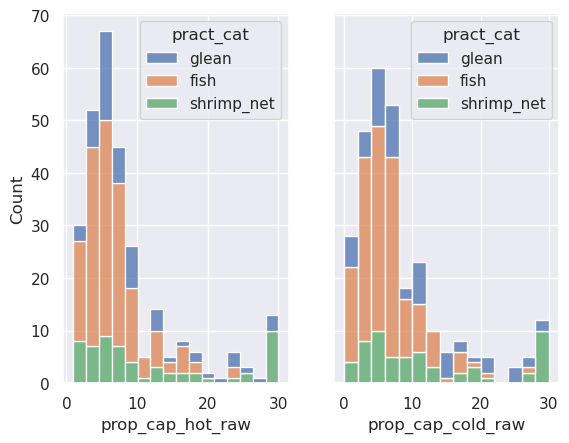

In [256]:
f, axes = plt.subplots(1, 2, sharey=True)
sns.histplot(data=df_wk, stat="count",multiple="stack", x="prop_cap_hot_raw", kde=False, hue="pract_cat", element="bars",legend=True, ax =axes[0])
sns.histplot(data=df_wk, stat="count",multiple="stack", x="prop_cap_cold_raw", kde=False, hue="pract_cat", element="bars",legend=True,ax =axes[1])

The data appears skewed because shrimp net fishers tend to have a high proportion of their catch come exclusively from one resource, namely shrimp (prawns). However this reprents real variation.

### Days per resource
Examine how many days per tide (15 days per tide, 2 tides per month) fishers collect a resource

In [257]:
df_wk['days_hot'].describe()

count    284.000000
mean       5.802817
std        4.032973
min        0.000000
25%        3.000000
50%        4.000000
75%        7.250000
max       15.000000
Name: days_hot, dtype: float64

In [258]:
df_wk['days_cold'].describe()

count    263.000000
mean       4.988593
std        3.972696
min        0.000000
25%        2.000000
50%        4.000000
75%        7.000000
max       15.000000
Name: days_cold, dtype: float64

<Axes: xlabel='days_cold', ylabel='Count'>

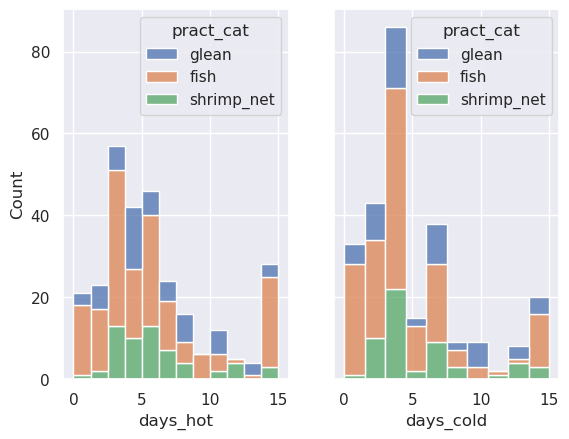

In [259]:
f, axes = plt.subplots(1, 2, sharey=True)
sns.histplot(data=df_wk, stat="count",multiple="stack", x="days_hot", kde=False, hue="pract_cat", element="bars",legend=True, ax =axes[0])
sns.histplot(data=df_wk, stat="count",multiple="stack", x="days_cold", kde=False, hue="pract_cat", element="bars",legend=True,ax =axes[1])

The responses here seem skewed. A thought is the fishers who were recorded as `15` responded "every day". Did they really mean every day? Or did they mean every day of the spring tide? Another important factor is that many fishers (but not all) have boats and can therefore still go out during the neap tide. I am not sure what do to with this skew.

In [260]:
df_wk.groupby('pract_cat')['days_hot'].describe()

,count,mean,std,min,25%,50%,75%,max
pract_cat,,,,,,,,
fish,165.0,5.678788,4.346274,0.0,3.00,4.0,7.0,15.0
glean,60.0,6.000000,3.746184,0.0,3.75,4.5,8.0,15.0
shrimp_net,59.0,5.949153,3.400932,1.0,3.00,5.0,7.0,15.0


This information is at the resource level. To try understand how many days in total respondents, we can approximate using the number of days from resource that they catch the most ofter. 

In [261]:
days_pp = df_wk.groupby(['ParentGlobalID','fish_pract']).agg(days_pp_hot=('days_hot', np.max), days_pp_cold = ('days_cold', np.max)).reset_index() 
days_pp.groupby('fish_pract')['days_pp_hot'].describe()

,count,mean,std,min,25%,50%,75%,max
fish_pract,,,,,,,,
basket_trap,1.0,1.000000,NaN,1.0,1.0,1.0,1.00,1.0
diving,2.0,9.000000,5.656854,5.0,7.0,9.0,11.00,13.0
drag_net,5.0,12.000000,4.472136,5.0,10.0,15.0,15.00,15.0
fence_trap,11.0,11.272727,4.051936,4.0,8.0,12.0,15.00,15.0
gill_net,18.0,8.000000,4.652640,3.0,4.0,7.0,13.25,15.0
glean,31.0,7.322581,3.664124,1.0,4.0,7.0,9.00,15.0
hand_line,14.0,6.571429,4.586171,0.0,3.5,6.5,8.50,15.0
shrimp_net,32.0,6.937500,3.340248,3.0,4.0,6.0,8.00,15.0


### Daily capture

Calculate daily capture. This is calculated as follows:
qantity captured* units* (kilograms/unit)

In [262]:

def cap_quant(units, quant):
    units_cv = float(unit_dict[units])
    if units_cv is not None:
        cap_p_mo = (quant* units_cv)
    else: 
        cap_p_mo = None
    return cap_p_mo

df_wk['cap_daily_hot'] = df_wk.apply(lambda row: cap_quant(row['cap_units_hot'], row['quant_cap_hot']), axis=1)
df_wk['cap_daily_cold'] = df_wk.apply(lambda row: cap_quant(row['cap_units_cold'], row['quant_cap_cold']), axis=1)



In [263]:
df_wk['cap_daily_hot'].describe()

count    277.000000
mean       9.465614
std       15.751729
min        0.250000
25%        2.000000
50%        4.000000
75%       12.000000
max      125.000000
Name: cap_daily_hot, dtype: float64

In [264]:
df_wk.groupby('fish_pract')['cap_daily_hot'].describe()

,count,mean,std,min,25%,50%,75%,max
fish_pract,,,,,,,,
basket_trap,1.0,0.625000,NaN,0.625,0.6250,0.6250,0.625,0.625
diving,2.0,11.000000,1.414214,10.000,10.5000,11.0000,11.500,12.000
drag_net,25.0,33.260000,36.367087,2.000,10.0000,15.0000,50.000,125.000
fence_trap,39.0,9.488462,8.255616,1.000,3.0000,7.5000,12.000,36.000
gill_net,57.0,13.658333,13.395376,0.500,5.0000,10.0000,15.000,60.000
glean,59.0,2.790042,3.013879,0.250,0.8750,1.5000,3.500,12.000
hand_line,35.0,3.407143,1.976038,0.250,2.0000,3.0000,4.000,8.000
shrimp_net,59.0,5.684958,7.703984,0.250,1.1375,3.0625,6.625,50.000


In [265]:
df_wk['cap_daily_cold'].describe()

count    253.000000
mean       6.320949
std       10.373776
min        0.000000
25%        1.000000
50%        3.000000
75%        6.000000
max       75.000000
Name: cap_daily_cold, dtype: float64

<Axes: xlabel='cap_daily_cold', ylabel='Count'>

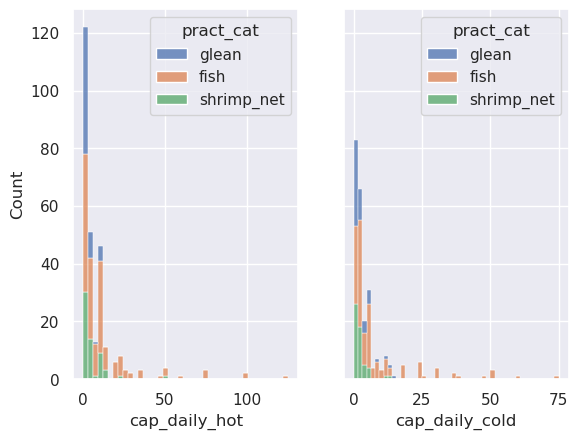

In [266]:
f, axes = plt.subplots(1, 2, sharey=True)
sns.histplot(data=df_wk, stat="count",multiple="stack", x="cap_daily_hot", kde=False, hue="pract_cat", element="bars",legend=True, ax =axes[0])
sns.histplot(data=df_wk, stat="count",multiple="stack", x="cap_daily_cold", kde=False, hue="pract_cat", element="bars",legend=True,ax =axes[1])

There are some outliers. Let's look at them.

In [267]:
outliers = df_wk[df_wk['cap_daily_hot']>(df_wk['cap_daily_hot'].mean()+3*df_wk['cap_daily_hot'].std())]
outliers[['id','fish_pract','quant_cap_hot', 'cap_units_hot','cap_daily_hot']]

,id,fish_pract,quant_cap_hot,cap_units_hot,cap_daily_hot
18,16022023NHMUB06,gill_net,5.0,basin,60.0
237,O1O22023MOR06,drag_net,5.0,Caixas,125.0
238,O1O22023MOR06,drag_net,3.0,caixas,75.0
242,01022023MORB07,drag_net,3.0,Caixas,75.0
243,01022023MORB07,drag_net,4.0,Caixas,100.0
245,01022023MORB07,drag_net,3.0,Caixas,75.0
271,24012023CUGB01,drag_net,4.0,Caixas,100.0


Unsurprisingly, the majority of these are drag nets, where 10-15 fishers use a singular large net

### Resell
Examine the income respondents made as "guevas" (or resellers of fishing resources) at a resource level

In [268]:
df_wk['resell_hot'].describe()

count      16.000000
mean     1184.375000
std      1884.650166
min         0.000000
25%         0.000000
50%       500.000000
75%       850.000000
max      5000.000000
Name: resell_hot, dtype: float64

In [269]:
df_wk['resell_cold'].describe()

count      16.000000
mean     1009.375000
std      1396.450112
min         0.000000
25%         0.000000
50%       400.000000
75%      1312.500000
max      4000.000000
Name: resell_cold, dtype: float64

<Axes: xlabel='resell_cold', ylabel='Count'>

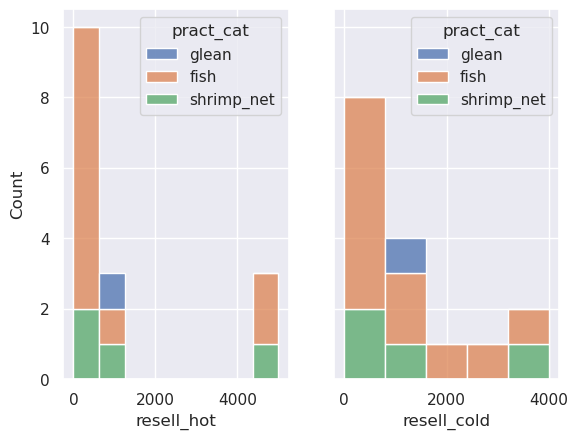

In [270]:
f, axes = plt.subplots(1, 2, sharey=True)
sns.histplot(data=df_wk, stat="count",multiple="stack", x="resell_hot", kde=False, hue="pract_cat", element="bars",legend=True, ax =axes[0])
sns.histplot(data=df_wk, stat="count",multiple="stack", x="resell_cold", kde=False, hue="pract_cat", element="bars",legend=True,ax =axes[1])

## Capture quantity

Exame the quantity of resource per month. This takes into account the number of days fish this resource each tide (remember 2 tides per month), daily catch, and the proportion of the catch they have a right to (if they fish in a group). The formula is as follows:

capture per month = (days caught per tide * 2)*(quantity captured per day) *(kilograms/units of capture)

In [271]:
# Calculate monthly catch
def cap_pp(days, units, quant, gear):
    days_p_mo = days*2
    units_cv = float(unit_dict[units])
    if units_cv is not None:
        cap_p_mo = (days_p_mo*quant* units_cv)
    else: 
        cap_p_mo = None
    return cap_p_mo


In [272]:
df_wk['cap_monthly_hot'] = df_wk.apply(lambda row: cap_pp(row['days_hot'], row['cap_units_hot'],  row['quant_cap_hot'], row['fish_pract']), axis=1)
df_wk['cap_monthly_hot'].describe()
df_wk

,id,focal_resource,gender,fish_pract,pract_cat,owner,catch_proportion,prop_cap_hot_raw,prop_cap_hot,days_hot,...,category,focal,communities,seagrass,Unnamed: 0,sg_dep_median,sg_dep_cat,cap_daily_hot,cap_daily_cold,cap_monthly_hot
0,13022023NHAMUB02,50,f,glean,glean,NaN,1.00,30,1.000000,4.0,...,crabs,1,"ilha,nhamua,josina_machel,chamane,marrambone,m...",2.0,9.0,3.0,high,1.0000,1.0000,8.00
1,16022023NHMUB05,60,f,glean,glean,NaN,1.00,10,0.333333,4.0,...,bivalve,1,"ilha,nhamua,josina_machel,chamane,sahane",2.0,15.0,3.0,high,0.7000,0.7000,5.60
2,16022023NHMUB05,61,f,glean,glean,NaN,1.00,7,0.233333,4.0,...,bivalve,1,"ilha,nhamua,josina_machel",2.0,16.0,3.0,high,0.8750,0.8750,7.00
3,16022023NHMUB07,01,m,gill_net,fish,owner,0.33,4,0.133333,3.0,...,fish,1,"ilha,nhamua,josina_machel,chamane,marrambone,m...",0.0,0.0,0.0,none,36.0000,24.0000,216.00
4,16022023NHMUB07,03,m,gill_net,fish,owner,0.33,3,0.100000,7.0,...,fish,1,"ilha,josina_machel,chamane,marrambone,mucucune...",1.0,2.0,0.5,none,12.0000,24.0000,168.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299,07022023CUGB06,56,m,fence_trap,fish,owner,1.00,17,0.566667,12.0,...,prawns,1,"ilha,nhamua,josina_machel,chamane,marrambone,m...",1.0,14.0,1.5,mod,4.0000,2.0000,96.00
300,07022023CUGB07,52,m,fence_trap,fish,owner,1.00,8,0.266667,5.0,...,crabs,1,"madava, kuguana, morrumbene",0.0,10.0,0.0,none,1.0000,2.0000,10.00
301,07022023CUGB07,53,m,fence_trap,fish,owner,1.00,12,0.400000,8.0,...,prawns,1,"madava,kuguana",0.0,11.0,0.0,none,2.0000,1.5000,32.00
302,07022023CUGB07,56,m,fence_trap,fish,owner,1.00,10,0.333333,8.0,...,prawns,1,"ilha,nhamua,josina_machel,chamane,marrambone,m...",1.0,14.0,1.5,mod,2.0000,1.0000,32.00


Examine the outliers

In [273]:
outliers= df_wk[df_wk['cap_monthly_hot']>(df_wk['cap_monthly_hot'].mean()+3*df_wk['cap_monthly_hot'].std())]
outliers[['id','fish_pract','days_hot','quant_cap_hot', 'cap_units_hot','cap_daily_hot','cap_monthly_hot']]

,id,fish_pract,days_hot,quant_cap_hot,cap_units_hot,cap_daily_hot,cap_monthly_hot
18,16022023NHMUB06,gill_net,14.0,5.0,basin,60.0,1680.0
238,O1O22023MOR06,drag_net,15.0,3.0,caixas,75.0,2250.0
243,01022023MORB07,drag_net,15.0,4.0,Caixas,100.0,3000.0
245,01022023MORB07,drag_net,15.0,3.0,Caixas,75.0,2250.0
269,24012023CUGB01,drag_net,15.0,2.0,caixas,50.0,1500.0
270,24012023CUGB01,gill_net,15.0,2.0,caixas,50.0,1500.0
271,24012023CUGB01,drag_net,15.0,4.0,Caixas,100.0,3000.0
274,24012023CUGB02,shrimp_net,15.0,50.0,kgs,50.0,1500.0
275,24012023CUGB02,gill_net,15.0,50.0,kgs,50.0,1500.0


These again appear to be mainly the same drag net records

In [274]:
# Remove outliers by assigning the cells Null values
df_viz = df_wk
df_viz.loc[df_viz['cap_monthly_hot']>(df_viz['cap_monthly_hot'].mean()+3*df_viz['cap_monthly_hot'].std()), "cap_monthly_hot"] = None 


In [275]:
df_wk['cap_monthly_cold'] = df_wk.apply(lambda row: cap_pp(row['days_cold'], row['cap_units_cold'],  row['quant_cap_cold'], row['fish_pract']), axis=1)
df_wk['cap_monthly_cold'].describe()

count     253.000000
mean       82.438142
std       211.569369
min         0.000000
25%         8.000000
50%        24.000000
75%        63.000000
max      1680.000000
Name: cap_monthly_cold, dtype: float64

Examine the outliers. 

In [276]:
outliers= df_wk[df_wk['cap_monthly_cold']>(df_wk['cap_monthly_cold'].mean()+3*df_wk['cap_monthly_cold'].std())]
outliers[['id','fish_pract','days_cold','quant_cap_cold', 'cap_units_cold','cap_daily_cold','cap_monthly_cold']]

,id,fish_pract,days_cold,quant_cap_cold,cap_units_cold,cap_daily_cold,cap_monthly_cold
95,02022023MARB07,gill_net,14.0,60.0,kgs,60.0,1680.0
238,O1O22023MOR06,drag_net,15.0,2.0,caixas,50.0,1500.0
266,24012023CUGB01,drag_net,15.0,2.0,caixas,50.0,1500.0
267,24012023CUGB01,gill_net,15.0,2.0,caixas,50.0,1500.0
273,24012023CUGB02,gill_net,15.0,2.0,basin,24.0,720.0


In [277]:
# Remove outliers by assigning the cells Null values
df_viz.loc[df_viz['cap_monthly_cold']>(df_viz['cap_monthly_cold'].mean()+3*df_viz['cap_monthly_cold'].std()), 'cap_monthly_cold'] = None 


<Axes: xlabel='cap_monthly_cold', ylabel='Count'>

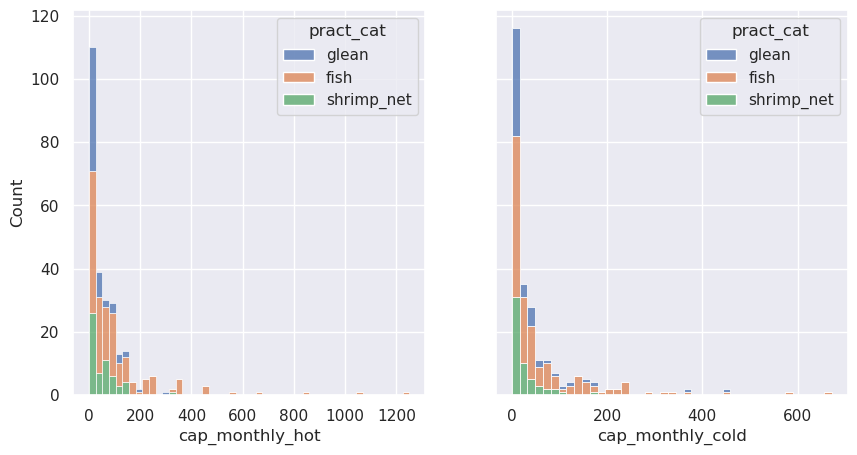

In [278]:
f, axes = plt.subplots(1, 2, sharey=True, figsize=(10,5))
sns.histplot(data=df_viz, stat="count",multiple="stack", x="cap_monthly_hot", kde=False, hue="pract_cat", element="bars",legend=True, ax =axes[0])
sns.histplot(data=df_viz, stat="count",multiple="stack", x="cap_monthly_cold", kde=False, hue="pract_cat", element="bars",legend=True,ax =axes[1])

In [279]:
df_wk.columns

Index(['id', 'focal_resource', 'gender', 'fish_pract', 'pract_cat', 'owner',
       'catch_proportion', 'prop_cap_hot_raw', 'prop_cap_hot', 'days_hot',
       'quant_cap_hot', 'cap_units_hot_label', 'cap_units_hot',
       ' cap_units_hot_other', 'sold_hot_raw', 'sold_hot', 'eaten_hot_raw',
       'eaten_hot', 'traded_hot_raw', 'traded_hot', 'offered_hot_raw',
       'offered_hot', 'sum_use_hot', 'sale_price_hot', 'sale_unit_hot',
       'sale_unit_hot_other', 'prop_cap_cold_raw', 'prop_cap_cold',
       'days_cold', 'quant_cap_cold', 'cap_units_cold', 'cap_units_cold_label',
       'cap_units_cold_other', 'sold_cold_raw', 'sold_cold', 'eaten_cold_raw',
       'eaten_cold', 'traded_cold_raw', 'traded_cold', 'offered_cold_raw',
       'offered_cold', 'sum_use_cold', 'sale_price_cold', 'sale_unit_cold',
       'sale_unit_cold_other', 'quant_traded', 'unit_traded',
       'unit_traded_other', 'product_recieved', 'product_other',
       'quant_recieved', 'unit_recieved', ' value_product_re

<Axes: xlabel='offered_cold', ylabel='Count'>

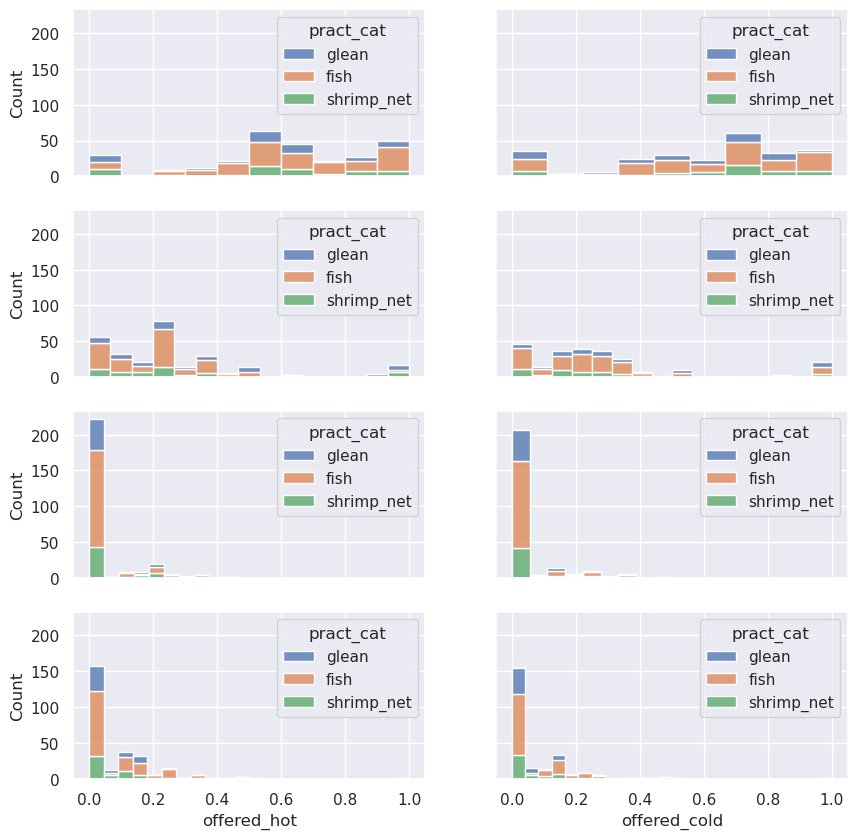

In [280]:
f, axes = plt.subplots(4, 2, sharey=True, sharex=True,figsize=(10,10))
axe = axes.ravel()
sns.histplot(data=df_viz, stat="count",multiple="stack", x="sold_hot", kde=False, hue="pract_cat", element="bars",legend=True, ax =axe[0])
sns.histplot(data=df_viz, stat="count",multiple="stack", x="sold_cold", kde=False, hue="pract_cat", element="bars",legend=True,ax =axe[1])
sns.histplot(data=df_viz, stat="count",multiple="stack", x="eaten_hot", kde=False, hue="pract_cat", element="bars",legend=True, ax =axe[2])
sns.histplot(data=df_viz, stat="count",multiple="stack", x="eaten_cold", kde=False, hue="pract_cat", element="bars",legend=True,ax =axe[3])
sns.histplot(data=df_viz, stat="count",multiple="stack", x="traded_hot", kde=False, hue="pract_cat", element="bars",legend=True, ax =axe[4])
sns.histplot(data=df_viz, stat="count",multiple="stack", x="traded_cold", kde=False, hue="pract_cat", element="bars",legend=True,ax =axe[5])
sns.histplot(data=df_viz, stat="count",multiple="stack", x="offered_hot", kde=False, hue="pract_cat", element="bars",legend=True, ax =axe[6])
sns.histplot(data=df_viz, stat="count",multiple="stack", x="offered_cold", kde=False, hue="pract_cat", element="bars",legend=True,ax =axe[7])

## Income per month

Calculate the income earned per species per month 

The formula is as follows:

2 (days captured) * (units captured per day) * (kilograms/unit) * (proportion of catch owned) * (proportion of catch sold) * (prince/unit)/(kilogram/unit)

In [281]:
# Calculate income per month
def income(days, cap_unit, cap_quant,catch_prop,sell_prop,price,sale_unit):
    units_sale_cv = float(unit_dict[sale_unit])
    units_cap_cv = float(unit_dict[cap_unit])
    
    income = days*2*units_cap_cv* cap_quant*catch_prop*sell_prop*(price/units_sale_cv)
    return income

#### Hot Season

In [282]:
df_wk['cap_income_hot'] = df_wk.apply(lambda row: income(row['days_hot'], row['cap_units_hot'],  row['quant_cap_hot'], row['catch_proportion'],  row['sold_hot'], row['sale_price_hot'], row['sale_unit_hot']), axis=1)
df_wk['cap_income_hot'].describe()

count       245.000000
mean       9128.089329
std       31605.266919
min           0.000000
25%         700.000000
50%        2250.000000
75%        6336.000000
max      303750.000000
Name: cap_income_hot, dtype: float64

In [283]:
outliers = df_wk[df_wk['cap_income_hot']>(df_wk['cap_income_hot'].mean()+3*df_wk['cap_income_hot'].std())]
outliers[['id','focal_resource','fish_pract','days_hot','cap_units_hot','quant_cap_hot','catch_proportion','sold_hot','sale_price_hot','sale_unit_hot','cap_monthly_hot','cap_income_hot']]

,id,focal_resource,fish_pract,days_hot,cap_units_hot,quant_cap_hot,catch_proportion,sold_hot,sale_price_hot,sale_unit_hot,cap_monthly_hot,cap_income_hot
269,24012023CUGB01,56,drag_net,15.0,caixas,2.0,0.30,0.900000,300.0,kgs,NaN,121500.0
270,24012023CUGB01,56,gill_net,15.0,caixas,2.0,0.75,0.900000,300.0,kgs,NaN,303750.0
275,24012023CUGB02,56,gill_net,15.0,kgs,50.0,1.00,0.600000,250.0,kgs,NaN,225000.0
276,24012023CUGB02,53,gill_net,15.0,kgs,15.0,1.00,0.866667,700.0,kgs,450.0,273000.0


In [284]:
# Remove outliers for plotting by assigning the cells Null values
df_viz = df_wk
df_viz.loc[df_viz['cap_income_hot']>(df_viz['cap_income_hot'].mean()+3*df_viz['cap_income_hot'].std()), 'cap_income_hot'] = None 

#### Cold Season

In [285]:
df_wk['cap_income_cold'] = df_wk.apply(lambda row: income(row['days_cold'], row['cap_units_cold'],  row['quant_cap_cold'], row['catch_proportion'],  row['sold_cold'], row['sale_price_cold'], row['sale_unit_cold']), axis=1)
df_wk['cap_income_cold'].describe()

count      215.000000
mean      4349.531041
std       7403.411254
min          0.000000
25%        483.000000
50%       1600.000000
75%       5040.000000
max      62720.000000
Name: cap_income_cold, dtype: float64

In [286]:
outliers = df_wk[df_wk['cap_income_cold']>(df_wk['cap_income_cold'].mean()+3*df_wk['cap_income_cold'].std())]
outliers[['id','focal_resource','fish_pract','days_cold','cap_units_cold','quant_cap_cold','catch_proportion','sold_cold','sale_price_cold','sale_unit_cold','cap_monthly_cold','cap_income_cold']]


,id,focal_resource,fish_pract,days_cold,cap_units_cold,quant_cap_cold,catch_proportion,sold_cold,sale_price_cold,sale_unit_cold,cap_monthly_cold,cap_income_cold
95,02022023MARB07,02,gill_net,14.0,kgs,60.0,1.0,0.366667,70.0,kgs,NaN,43120.0
152,08022023MADB05,53,gill_net,7.0,kgs,4.0,1.0,1.000000,750.0,kgs,56.0,42000.0
276,24012023CUGB02,53,gill_net,4.0,kgs,10.5,1.0,0.933333,800.0,kgs,84.0,62720.0


In [287]:
# Remove outliers for plotting by assigning the cells Null values
df_viz.loc[df_viz['cap_income_cold']>(df_viz['cap_income_cold'].mean()+3*df_viz['cap_income_cold'].std()), 'cap_income_cold'] = None 

<Axes: xlabel='cap_income_cold', ylabel='Count'>

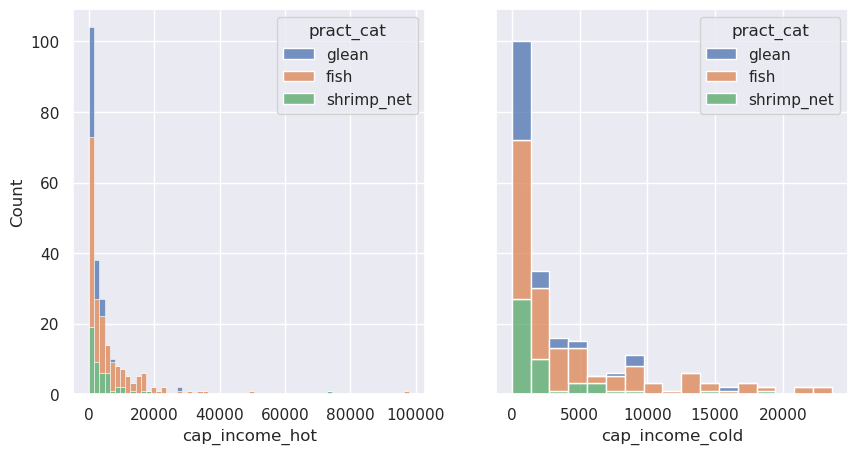

In [288]:
f, axes = plt.subplots(1, 2, sharey=True, figsize=(10,5))
sns.histplot(data=df_viz, stat="count",multiple="stack", x="cap_income_hot", kde=False, hue="pract_cat", element="bars",legend=True, ax =axes[0])
sns.histplot(data=df_viz, stat="count",multiple="stack", x="cap_income_cold", kde=False, hue="pract_cat", element="bars",legend=True,ax =axes[1])

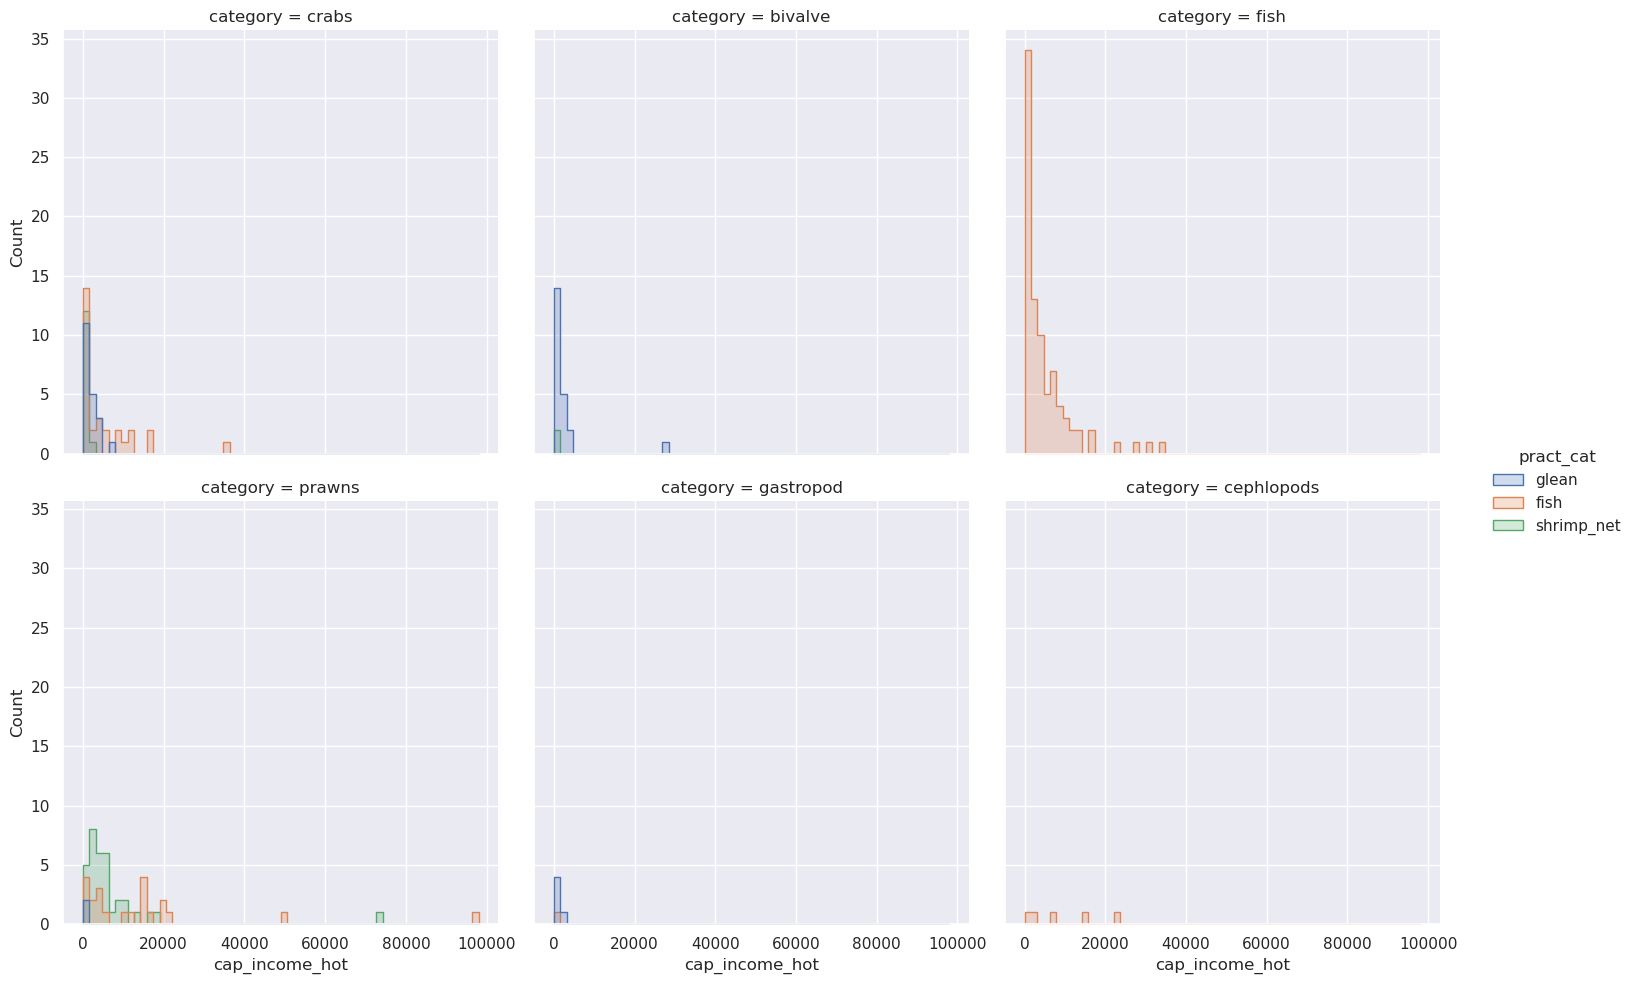

In [289]:
sns.displot(df_viz, x="cap_income_hot", col="category", hue="pract_cat", element="step", col_wrap = 3)

### Trade
Some fishing resources are traded for goods. The exchange value of resources was calculated as followed:

trade value = 2 (days fished) (units captured) (kilograms/unit) (proportion of capture traded) (value of traded product)/(units of product traded * kilograms / unit )

In [290]:
def trade_val(days, cap_unit, cap_quant, trade_prop, quant_traded, trade_unit,value):
    if trade_prop > 0:
        units_trade_cv = float(unit_dict[trade_unit])
        units_cap_cv = float(unit_dict[cap_unit])
        val=days*2*units_cap_cv*cap_quant*trade_prop*(value/(quant_traded*units_trade_cv))
    else:
        val = None
    return val

#### Hot Season

In [291]:
df_wk['val_trade_hot'] = df_wk.apply(lambda row: trade_val(row['days_hot'], row['cap_units_hot'],  row['quant_cap_hot'],row['traded_hot'], row['quant_traded'],  row['unit_traded'], row[' value_product_recieved']), axis=1)
df_wk['val_trade_hot'].describe()

count       57.000000
mean      3518.042607
std       6170.095775
min         33.333333
25%        420.000000
50%       1170.000000
75%       2560.000000
max      24000.000000
Name: val_trade_hot, dtype: float64

In [292]:
# Remove outliers by assigning the cells Null values
df_viz = df_wk
df_viz.loc[df_viz['val_trade_hot']>(df_viz['val_trade_hot'].mean()+3*df_viz['val_trade_hot'].std()), 'val_trade_hot'] = None 
# df_wk

#### Cold Season

In [293]:
df_wk['val_trade_cold'] = df_wk.apply(lambda row: trade_val(row['days_cold'], row['cap_units_cold'],  row['quant_cap_cold'], row['traded_cold'], row['quant_traded'],  row['unit_traded'], row[' value_product_recieved']), axis=1)
df_wk['val_trade_cold'].describe()

count       46.000000
mean      1999.341184
std       4788.988731
min         53.333333
25%        309.000000
50%        697.222222
75%       1666.666667
max      31500.000000
Name: val_trade_cold, dtype: float64

In [294]:
# Remove outliers by assigning the cells Null values
df_viz.loc[df_viz['val_trade_cold']>(df_viz['val_trade_cold'].mean()+3*df_viz['val_trade_cold'].std()), 'val_trade_cold'] = None 
# df_wk

<Axes: xlabel='val_trade_cold', ylabel='Count'>

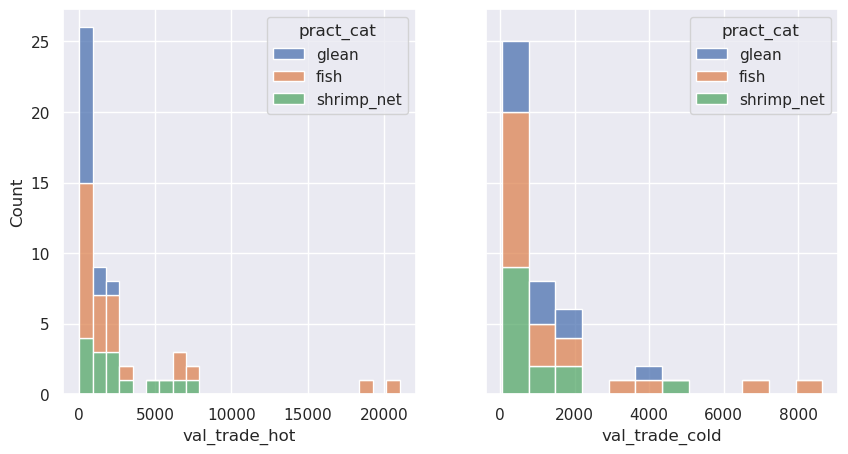

In [295]:
f, axes = plt.subplots(1, 2, sharey=True, figsize=(10,5))
sns.histplot(data=df_viz, stat="count",multiple="stack", x="val_trade_hot", kde=False, hue="pract_cat", element="bars",legend=True, ax =axes[0])
sns.histplot(data=df_viz, stat="count",multiple="stack", x="val_trade_cold", kde=False, hue="pract_cat", element="bars",legend=True,ax =axes[1])

## Proportion of Income

The proportion of income from a resource in the repeate table will be calculates as follows:
(income from resource)/[(total income from fishing resources)+(income from other activities)]
where
income from resource = income from capture sale + exchange value of trades + income from reselling 

Load in the data on income from other activities in the activity repeat table. Sum income at the activity level by responent for each season to get their total non-fishing income.

In [296]:
# Calculate proportion of income 

# read in the income resource table, which records other income outside of fishing at the activity level for each respondent
inc_raw = os.path.join(sur_B_raw, "other_income_table_3.csv")
df_inc_raw = pd.read_csv(inc_raw)

# agreegate the activity income at the respondent level to sum up the total non-fishing income per respondent during the hot and cold season
df_inc = df_inc_raw.groupby(['ParentGlobalID']).agg({'activity_income_hot': 'sum','activity_income_cold': 'sum'}).reset_index() 

df_inc

,ParentGlobalID,activity_income_hot,activity_income_cold
0,0452b1c9-a249-4667-bf24-bb6969858009,0,1500
1,0d25df79-dc4d-42aa-9bc9-3b705d683d68,38000,38000
2,217d4e9d-94cc-407a-9aaf-9dabfa977971,2000,0
3,21b02f45-d7ae-4f05-9a52-89dad34349af,750,750
4,275be6f1-5e39-4787-a0f6-e532bee2ef83,0,1250
5,2dd5e1ed-eeed-47b2-827d-a0705fc23c7a,0,300
6,310a5eff-b95e-4979-a0dd-c98a7703f436,6000,6000
7,339c9818-8caa-4798-9a51-85ba26bc71c3,5000,5000
8,3f3b6da1-f4ee-467b-9647-aefe9851351f,0,280
9,412ebe42-d0ab-49cd-a390-790fb5dd06a9,16500,16500


Sum the income from the sale of captured reesources, the exchange value of traded resources, and the income from reselling by Parent ID to get the totals for each respondent. Merge the fishing income total table and non-fishing income total table with the capture table.

In [297]:
# aggregate the capture level data at the respondent level to sum up the total income from fishing during the hot and cold seasons 
# and the total equivalent value of traded products during the hot and cold season
df_wk_inc = df_wk.groupby(['ParentGlobalID']).agg(tot_cap_income_hot=('cap_income_hot', np.sum), tot_val_trade_hot = ('val_trade_hot', np.sum), tot_resell_income_hot = ('resell_hot', np.sum), tot_cap_income_cold = ('cap_income_cold', np.sum), tot_val_trade_cold = ('val_trade_cold', np.sum), tot_resell_income_cold = ('resell_cold', np.sum)).reset_index() 
print("length before merge = "+ str(len(df_wk_inc)))

# merge the non-fishing activity income table with the capture table
df_wk_inc = pd.merge(df_wk_inc,df_inc,on=['ParentGlobalID'], how='left')
print("length after merge = "+ str(len(df_wk_inc)))
# merage the total fishing-income table with the capture table
df_wk = pd.merge(df_wk,df_wk_inc,on=['ParentGlobalID'], how='left')
print("length after merge = "+ str(len(df_wk)))

df_wk

length before merge = 95
length after merge = 95
length after merge = 284


,id,focal_resource,gender,fish_pract,pract_cat,owner,catch_proportion,prop_cap_hot_raw,prop_cap_hot,days_hot,...,val_trade_hot,val_trade_cold,tot_cap_income_hot,tot_val_trade_hot,tot_resell_income_hot,tot_cap_income_cold,tot_val_trade_cold,tot_resell_income_cold,activity_income_hot,activity_income_cold
0,13022023NHAMUB02,50,f,glean,glean,NaN,1.00,30,1.000000,4.0,...,NaN,NaN,333.333333,0.0,0.0,333.333333,0.0,0.0,300.0,300.0
1,16022023NHMUB05,60,f,glean,glean,NaN,1.00,10,0.333333,4.0,...,170.666667,170.666667,766.666667,304.0,0.0,766.666667,304.0,0.0,0.0,280.0
2,16022023NHMUB05,61,f,glean,glean,NaN,1.00,7,0.233333,4.0,...,133.333333,133.333333,766.666667,304.0,0.0,766.666667,304.0,0.0,0.0,280.0
3,16022023NHMUB07,01,m,gill_net,fish,owner,0.33,4,0.133333,3.0,...,NaN,NaN,16632.000000,0.0,0.0,38544.000000,0.0,0.0,NaN,NaN
4,16022023NHMUB07,03,m,gill_net,fish,owner,0.33,3,0.100000,7.0,...,NaN,NaN,16632.000000,0.0,0.0,38544.000000,0.0,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
279,07022023CUGB06,56,m,fence_trap,fish,owner,1.00,17,0.566667,12.0,...,NaN,NaN,30100.000000,0.0,0.0,10653.333333,0.0,0.0,NaN,NaN
280,07022023CUGB07,52,m,fence_trap,fish,owner,1.00,8,0.266667,5.0,...,NaN,NaN,0.000000,0.0,0.0,0.000000,0.0,0.0,NaN,NaN
281,07022023CUGB07,53,m,fence_trap,fish,owner,1.00,12,0.400000,8.0,...,NaN,NaN,0.000000,0.0,0.0,0.000000,0.0,0.0,NaN,NaN
282,07022023CUGB07,56,m,fence_trap,fish,owner,1.00,10,0.333333,8.0,...,NaN,NaN,0.000000,0.0,0.0,0.000000,0.0,0.0,NaN,NaN


Any `NaN` values need to be replaced with 0 (0 income)

In [298]:
# list of columns where NaN values should be 0s for computations 
fill_0s = ['activity_income_hot','activity_income_cold','tot_cap_income_hot','tot_cap_income_cold','cap_income_hot','cap_income_cold', 'tot_val_trade_hot', 'val_trade_hot', 'val_trade_cold', 'tot_val_trade_cold', 'tot_resell_income_hot', 'tot_resell_income_cold' , 'resell_hot', 'resell_cold']

# fill NaNs with zeros 
for col in fill_0s:
    df_wk[col].fillna(0, inplace=True)

df_wk

,id,focal_resource,gender,fish_pract,pract_cat,owner,catch_proportion,prop_cap_hot_raw,prop_cap_hot,days_hot,...,val_trade_hot,val_trade_cold,tot_cap_income_hot,tot_val_trade_hot,tot_resell_income_hot,tot_cap_income_cold,tot_val_trade_cold,tot_resell_income_cold,activity_income_hot,activity_income_cold
0,13022023NHAMUB02,50,f,glean,glean,NaN,1.00,30,1.000000,4.0,...,0.000000,0.000000,333.333333,0.0,0.0,333.333333,0.0,0.0,300.0,300.0
1,16022023NHMUB05,60,f,glean,glean,NaN,1.00,10,0.333333,4.0,...,170.666667,170.666667,766.666667,304.0,0.0,766.666667,304.0,0.0,0.0,280.0
2,16022023NHMUB05,61,f,glean,glean,NaN,1.00,7,0.233333,4.0,...,133.333333,133.333333,766.666667,304.0,0.0,766.666667,304.0,0.0,0.0,280.0
3,16022023NHMUB07,01,m,gill_net,fish,owner,0.33,4,0.133333,3.0,...,0.000000,0.000000,16632.000000,0.0,0.0,38544.000000,0.0,0.0,0.0,0.0
4,16022023NHMUB07,03,m,gill_net,fish,owner,0.33,3,0.100000,7.0,...,0.000000,0.000000,16632.000000,0.0,0.0,38544.000000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
279,07022023CUGB06,56,m,fence_trap,fish,owner,1.00,17,0.566667,12.0,...,0.000000,0.000000,30100.000000,0.0,0.0,10653.333333,0.0,0.0,0.0,0.0
280,07022023CUGB07,52,m,fence_trap,fish,owner,1.00,8,0.266667,5.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
281,07022023CUGB07,53,m,fence_trap,fish,owner,1.00,12,0.400000,8.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
282,07022023CUGB07,56,m,fence_trap,fish,owner,1.00,10,0.333333,8.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


In [299]:
# fucntion to calculate proportion of income from a resource
def total_income_resource(income, trade_val, resell):
    total_income_resource = income+ trade_val+ resell
    return total_income_resource

df_wk['income_fr_hot'] = df_wk.apply(lambda row: total_income_resource(row['cap_income_hot'],row['val_trade_hot'], row['resell_hot']), axis=1)
df_wk['income_fr_cold'] = df_wk.apply(lambda row: total_income_resource(row['cap_income_cold'],row['val_trade_cold'], row['resell_cold']), axis=1)

def total_income_respondent( income_tot_fish, trade_tot, other_income, resell_tot):
    total_income_respondent = trade_tot + income_tot_fish + other_income + resell_tot
    return total_income_respondent

df_wk['tot_income_hot'] = df_wk.apply(lambda row: total_income_respondent(row['tot_cap_income_hot'], row['tot_val_trade_hot'], row['activity_income_hot'], row['tot_resell_income_hot']), axis=1)
df_wk['tot_income_cold'] = df_wk.apply(lambda row: total_income_respondent(row['tot_cap_income_cold'], row['tot_val_trade_cold'], row['activity_income_cold'], row['tot_resell_income_cold']), axis=1)

def prop_income(total_income_resource,total_income_respondent):
    if total_income_resource != 0 and total_income_respondent != 0:
        prop = (total_income_resource)/(total_income_respondent)
    else:
        prop = 0
    return prop

df_wk['prop_income_hot'] = df_wk.apply(lambda row: prop_income(row['income_fr_hot'],row['tot_income_hot']), axis=1)
df_wk['prop_income_cold'] = df_wk.apply(lambda row: prop_income(row['income_fr_cold'],row['tot_income_cold']), axis=1)

df_wk


,id,focal_resource,gender,fish_pract,pract_cat,owner,catch_proportion,prop_cap_hot_raw,prop_cap_hot,days_hot,...,tot_val_trade_cold,tot_resell_income_cold,activity_income_hot,activity_income_cold,income_fr_hot,income_fr_cold,tot_income_hot,tot_income_cold,prop_income_hot,prop_income_cold
0,13022023NHAMUB02,50,f,glean,glean,NaN,1.00,30,1.000000,4.0,...,0.0,0.0,300.0,300.0,333.333333,333.333333,633.333333,633.333333,0.526316,0.526316
1,16022023NHMUB05,60,f,glean,glean,NaN,1.00,10,0.333333,4.0,...,304.0,0.0,0.0,280.0,437.333333,437.333333,1070.666667,1350.666667,0.408468,0.323791
2,16022023NHMUB05,61,f,glean,glean,NaN,1.00,7,0.233333,4.0,...,304.0,0.0,0.0,280.0,633.333333,633.333333,1070.666667,1350.666667,0.591532,0.468904
3,16022023NHMUB07,01,m,gill_net,fish,owner,0.33,4,0.133333,3.0,...,0.0,0.0,0.0,0.0,9979.200000,12830.400000,16632.000000,38544.000000,0.600000,0.332877
4,16022023NHMUB07,03,m,gill_net,fish,owner,0.33,3,0.100000,7.0,...,0.0,0.0,0.0,0.0,5174.400000,4276.800000,16632.000000,38544.000000,0.311111,0.110959
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
279,07022023CUGB06,56,m,fence_trap,fish,owner,1.00,17,0.566667,12.0,...,0.0,0.0,0.0,0.0,15200.000000,5320.000000,30100.000000,10653.333333,0.504983,0.499374
280,07022023CUGB07,52,m,fence_trap,fish,owner,1.00,8,0.266667,5.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
281,07022023CUGB07,53,m,fence_trap,fish,owner,1.00,12,0.400000,8.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
282,07022023CUGB07,56,m,fence_trap,fish,owner,1.00,10,0.333333,8.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [300]:
def prop_income_from_trade(trade_val, income_tot_fish, trade_tot, other_income, income_resell):
    if trade_val != 0:
        prop = (trade_val)/(trade_tot+income_tot_fish + other_income+income_resell)
    if trade_val == 0:
        prop = 0
    return prop

df_wk['prop_income_from_trade_hot'] = df_wk.apply(lambda row: prop_income_from_trade(row['val_trade_hot'],row['tot_cap_income_hot'], row['tot_val_trade_hot'], row['activity_income_hot'], row['tot_resell_income_hot']), axis=1)
df_wk['prop_income_from_trade_cold'] = df_wk.apply(lambda row: prop_income_from_trade(row['val_trade_cold'],row['tot_cap_income_cold'], row['tot_val_trade_cold'], row['activity_income_cold'], row['tot_resell_income_cold']), axis=1)

In [301]:
df_wk['prop_income_hot'].describe()

count    284.000000
mean       0.303317
std        0.329745
min        0.000000
25%        0.026674
50%        0.188718
75%        0.486486
max        1.000000
Name: prop_income_hot, dtype: float64

<Axes: xlabel='prop_income_hot', ylabel='Count'>

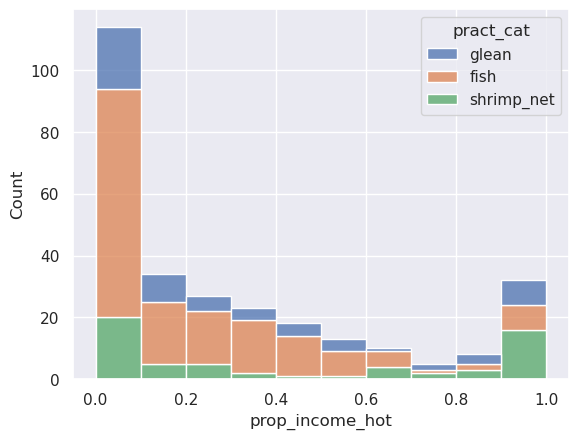

In [302]:
sns.histplot(df_wk, multiple="stack", x="prop_income_hot", hue="pract_cat")

In [303]:
df_wk['prop_income_cold'].describe()

count    284.000000
mean       0.276143
std        0.310093
min        0.000000
25%        0.000000
50%        0.170059
75%        0.445338
max        1.000000
Name: prop_income_cold, dtype: float64

<Axes: xlabel='prop_income_cold', ylabel='Count'>

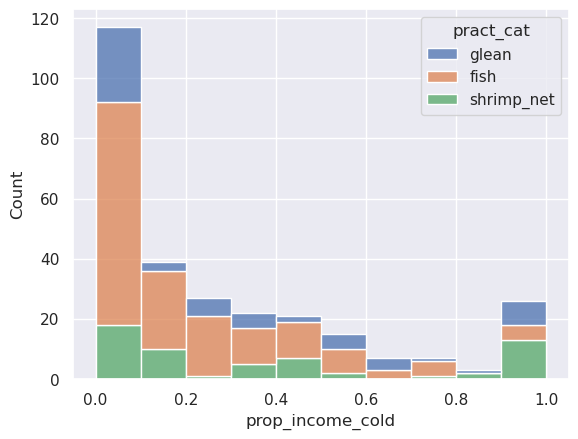

In [304]:
sns.histplot(data=df_wk, stat="count",multiple="stack", x="prop_income_cold", kde=False, hue="pract_cat", element="bars",legend=True)

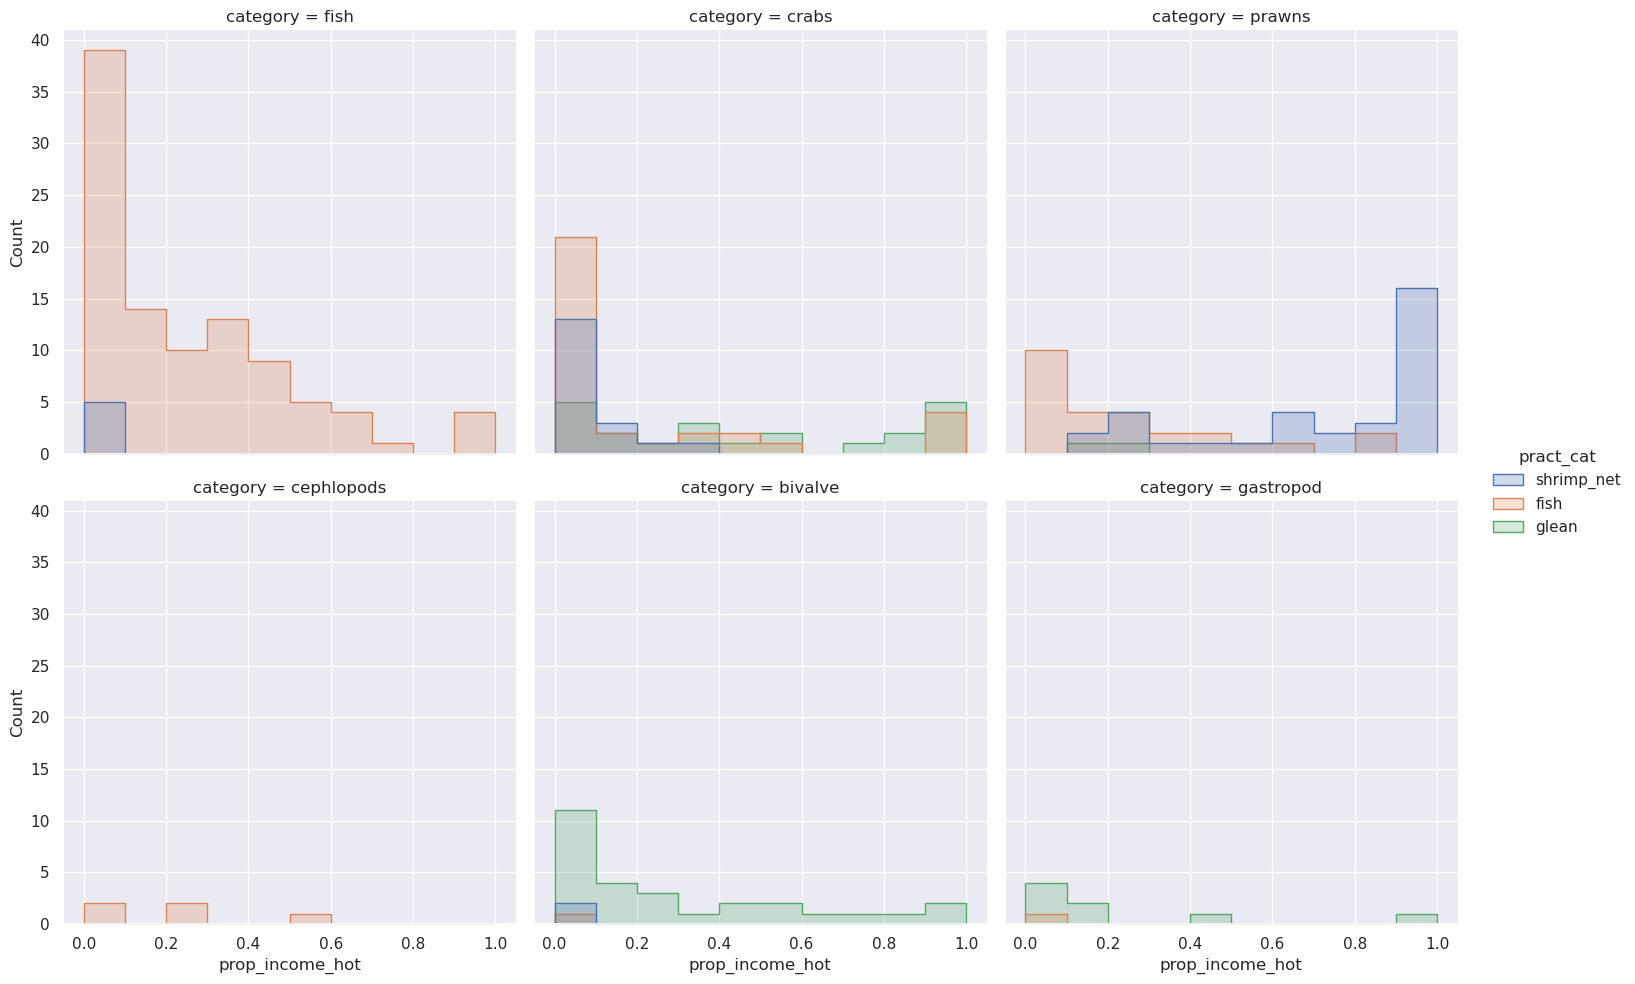

In [305]:
df_wk.sort_values(by='focal_resource', ascending=True,inplace=True)
sns.displot(df_wk, x="prop_income_hot", col="category", hue="pract_cat", element="step", col_wrap = 3)

In [306]:
df_wk.columns

Index(['id', 'focal_resource', 'gender', 'fish_pract', 'pract_cat', 'owner',
       'catch_proportion', 'prop_cap_hot_raw', 'prop_cap_hot', 'days_hot',
       'quant_cap_hot', 'cap_units_hot_label', 'cap_units_hot',
       ' cap_units_hot_other', 'sold_hot_raw', 'sold_hot', 'eaten_hot_raw',
       'eaten_hot', 'traded_hot_raw', 'traded_hot', 'offered_hot_raw',
       'offered_hot', 'sum_use_hot', 'sale_price_hot', 'sale_unit_hot',
       'sale_unit_hot_other', 'prop_cap_cold_raw', 'prop_cap_cold',
       'days_cold', 'quant_cap_cold', 'cap_units_cold', 'cap_units_cold_label',
       'cap_units_cold_other', 'sold_cold_raw', 'sold_cold', 'eaten_cold_raw',
       'eaten_cold', 'traded_cold_raw', 'traded_cold', 'offered_cold_raw',
       'offered_cold', 'sum_use_cold', 'sale_price_cold', 'sale_unit_cold',
       'sale_unit_cold_other', 'quant_traded', 'unit_traded',
       'unit_traded_other', 'product_recieved', 'product_other',
       'quant_recieved', 'unit_recieved', ' value_product_re

In [307]:

df_final=df_wk[['focal_resource', 'gitonga_s','gitonga_p', 'portuguese', 
                'scientific', 'family', 'phylum', 'category','focal', 
                'sg_dep_median', 'sg_dep_cat', 'prop_cap_hot', 'prop_cap_cold', 
                'days_hot', 'days_cold', 'cap_daily_hot','cap_daily_cold', 
                'cap_monthly_hot', 'cap_monthly_cold','cap_income_hot', 'cap_income_cold', 
                'val_trade_hot', 'val_trade_cold', 'activity_income_hot', 'activity_income_cold', 
                'income_fr_hot','income_fr_cold', 'tot_income_hot', 'tot_income_cold', 
                'prop_income_hot','prop_income_cold','id', 'ccp', 'gender', 
                'fish_pract', 'pract_cat','seagrass']]
df_final.to_csv('../capture_table_clean.csv')

In [308]:
df_final=df_wk[['focal_resource', 'gitonga_s','gitonga_p', 'portuguese', 
                'scientific', 'family', 'phylum', 'category', 'sg_dep_cat',
                'cap_income_hot', 'cap_income_cold', 
                'prop_income_hot','prop_income_cold','id', 'ccp', 'gender', 
                'fish_pract', 'pract_cat']]
df_final.to_csv('../income_table_clean.csv')

In [309]:
df_final=df_wk[['focal_resource', 'gitonga_s','gitonga_p', 'portuguese', 
                'scientific', 'family', 'phylum', 'category', 'sg_dep_cat', 
                'prop_cap_hot', 'prop_cap_cold', 
                'cap_monthly_hot', 'cap_monthly_cold',  
                'id', 'ccp', 'gender', 
                'fish_pract', 'pract_cat']]
df_final.to_csv('../captured_table_clean.csv')